In [9]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm

import sys
from pathlib import Path

sys.path.insert(0, str(Path("..").resolve()))

from utils import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
img_size = 32
batch_size = 100
validation_split = 0.2
embed_dim = 2
epochs = 5
beta = 500

### Data Preprocessing

In [11]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [12]:
def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

In [13]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)

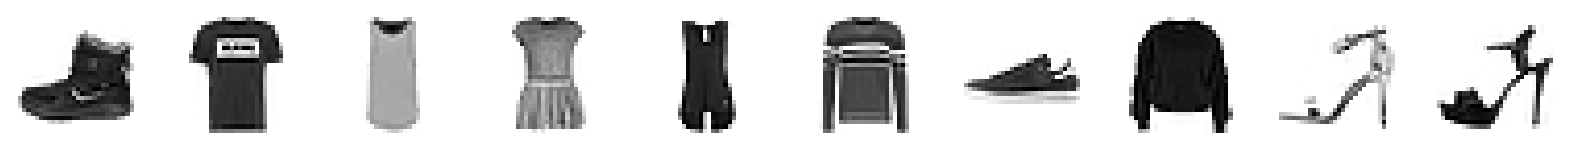

In [14]:
display(x_train)

### Model

In [20]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [21]:
#encoder 
encoder_input = layers.Input(shape=(img_size, img_size,1), name="encoder_input")
x = layers.Conv2D(32, 3, strides=2, activation="relu", padding="same")(encoder_input)
x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]
x = layers.Flatten()(x)
z_mean = layers.Dense(embed_dim, name="z_mean")(x)
z_log_var = layers.Dense(embed_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")


In [41]:
#decoder
decoder_input = layers.Input(shape=(embed_dim, ), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same")(x)
decoder_output = layers.Conv2D(1, 3, strides=1, activation="sigmoid", padding="same", name="decoder_output")(x)
decoder = models.Model(decoder_input, decoder_output)

In [58]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                beta
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            beta
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [59]:
vae = VAE(encoder, decoder)

### Training

In [60]:
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [61]:
vae.fit(
    x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=x_test,
)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - kl_loss: 5.1188 - reconstruction_loss: 131.8955 - total_loss: 137.0144 - val_kl_loss: 5.0037 - val_loss: 138.5491 - val_reconstruction_loss: 133.5454
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 41s 69ms/step - kl_loss: 5.0185 - reconstruction_loss: 129.7508 - total_loss: 134.7692 - val_kl_loss: 5.1320 - val_loss: 137.5139 - val_reconstruction_loss: 132.3819
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - kl_loss: 5.0399 - reconstruction_loss: 128.7172 - total_loss: 133.7572 - val_kl_loss: 5.2514 - val_loss: 136.3307 - val_reconstruction_loss: 131.0792
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 41s 69ms/step - kl_loss: 5.0513 - reconstruction_loss: 128.0183 - total_loss: 133.0697 - val_kl_loss: 5.1381 - val_loss: 136.3780 - val_reconstruction_loss: 131.2399
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 42s 70ms/step - kl_loss: 5.0976 - reconstruction_loss: 127.6014 - total_loss: 132.6990 - val_kl_loss: 5.0854 - val_loss: 135.5324 - val_recon

### Testing

In [62]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Example real clothing items


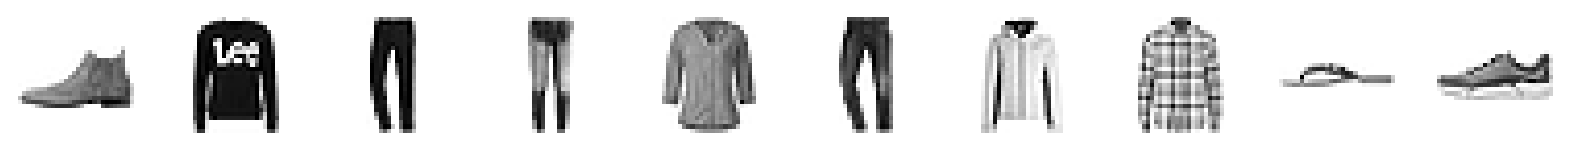

Reconstructions


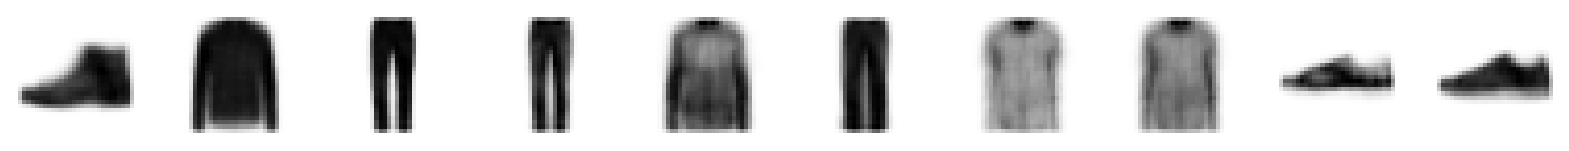

In [63]:
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(reconstructions)

In [64]:
z_mean, z_var, z = encoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [65]:
print(z[:10])

[[-0.83432376  1.2017487 ]
 [ 1.1163797  -0.03674253]
 [ 0.14440691 -2.821806  ]
 [-0.7850164  -2.0684052 ]
 [ 0.14504494 -0.12875837]
 [ 0.41391444 -1.6259453 ]
 [-0.82169956 -0.5003648 ]
 [-0.340045   -0.34882033]
 [-2.5215437   0.23867849]
 [-1.9802544   0.6205719 ]]


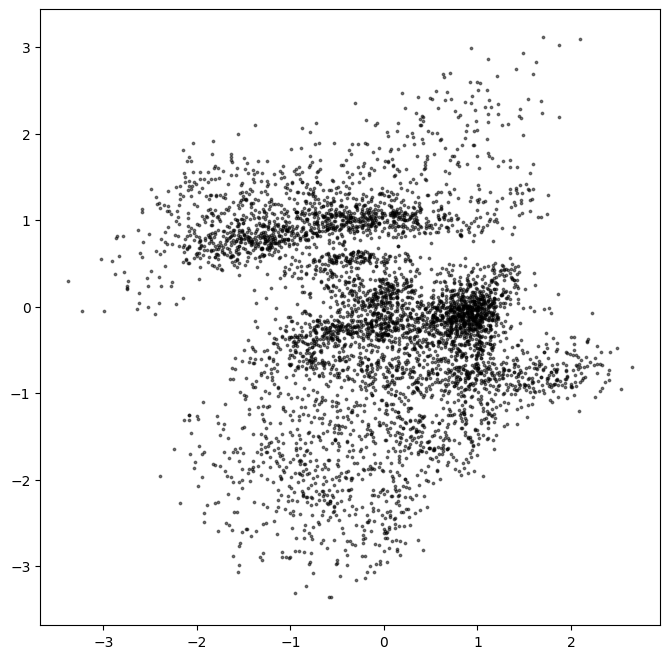

In [66]:
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

### Sample some points in the latent space

In [67]:
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [68]:
reconstructions = decoder.predict(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


In [69]:
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

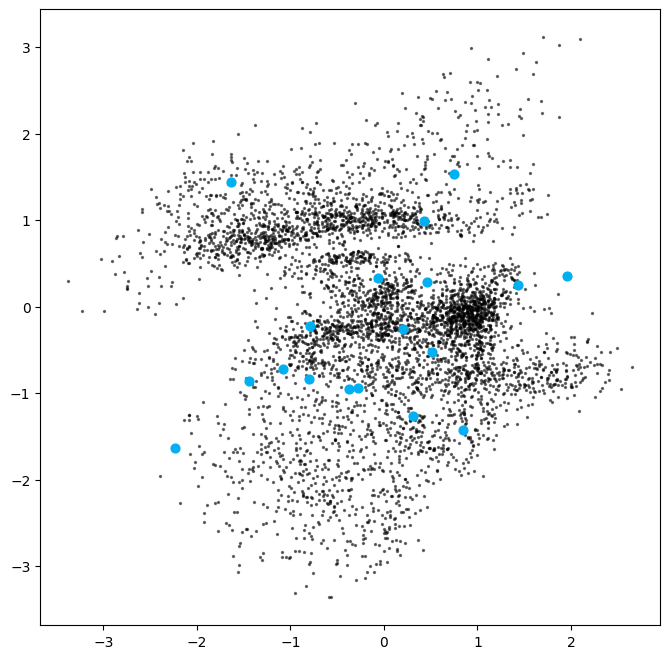

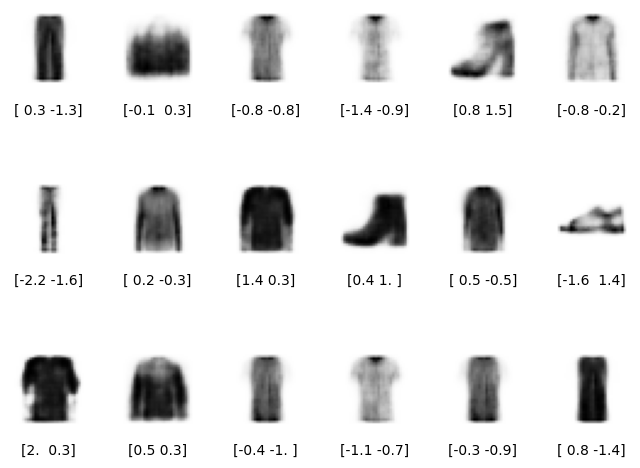

In [70]:
figsize = 8
plt.figure(figsize=(figsize, figsize))

#original embeddings
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

#newly generated points
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

#grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

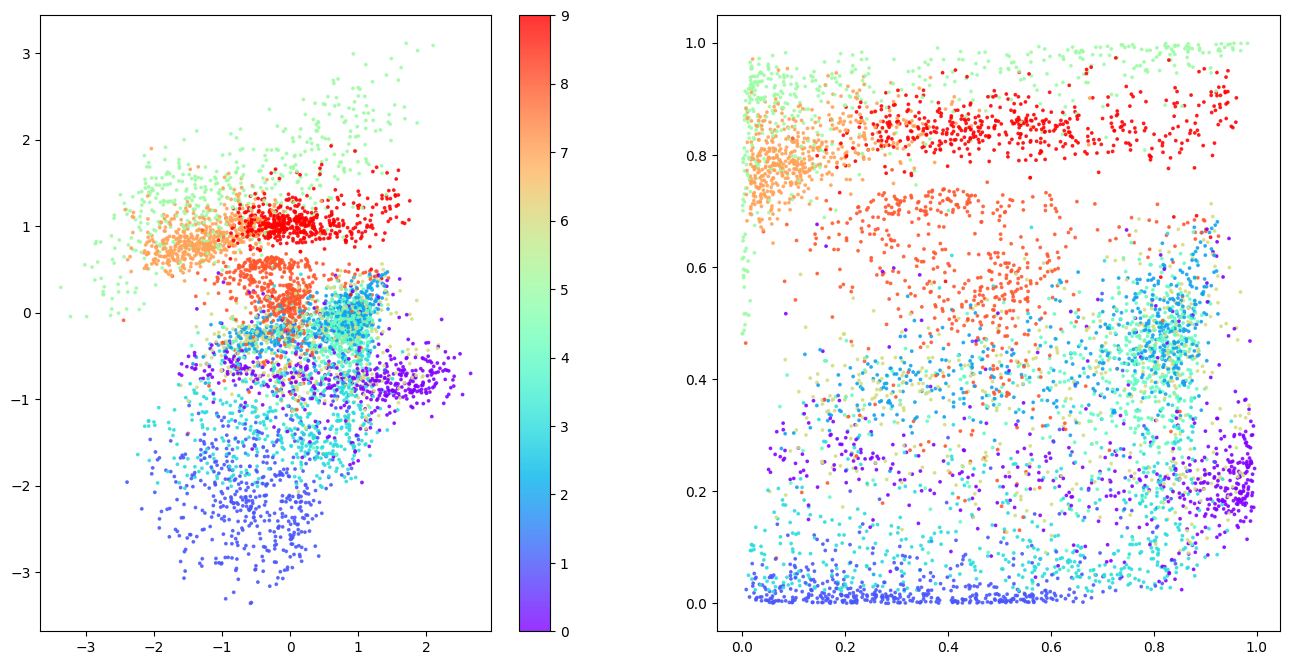

In [71]:
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


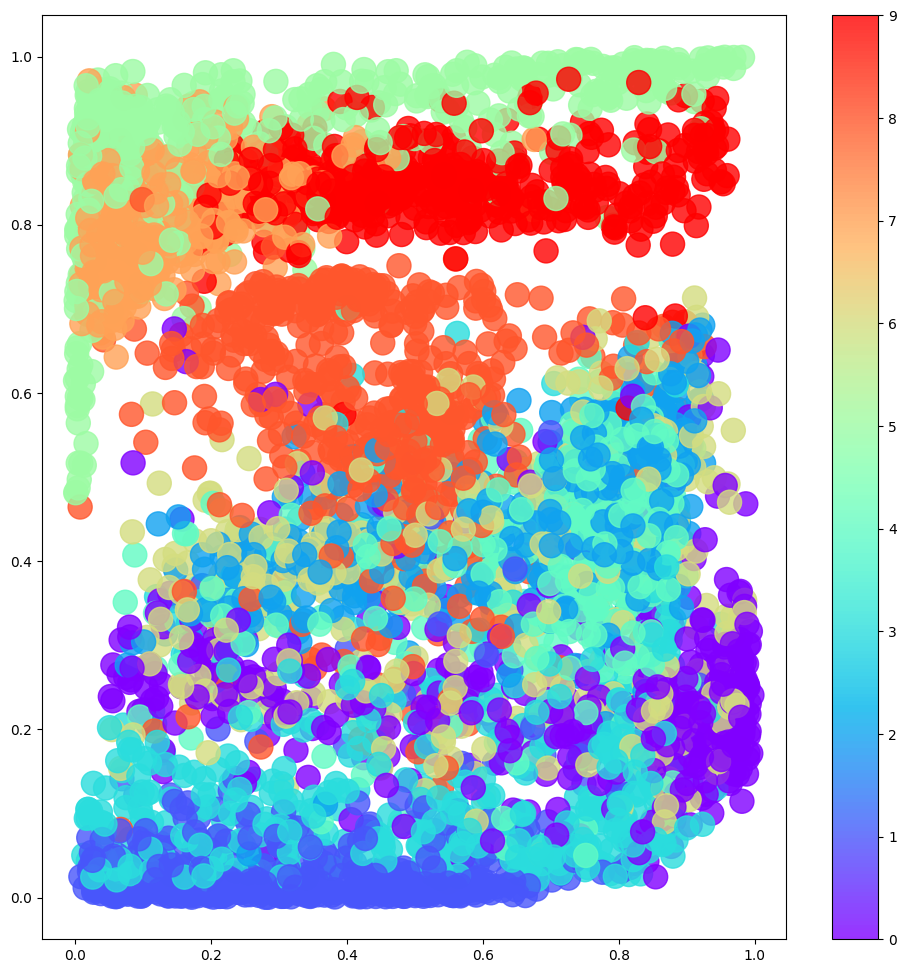

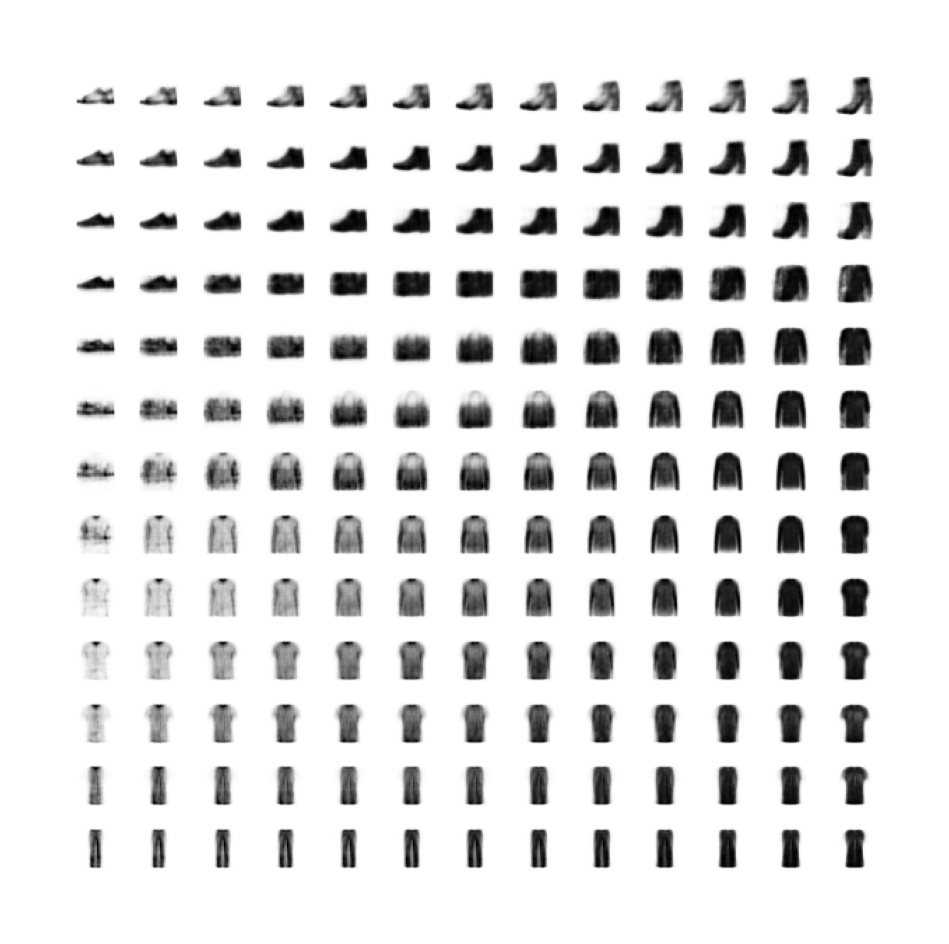

In [74]:
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")